In [3]:
!pip install transformers
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 87.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 6.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [4]:

import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
import torch 
import torch.nn as nn 

device = torch.device('cuda')

In [5]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# set working directory 
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [7]:
# load dataset 
true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

# generate labels true/false 
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# merge 
data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

print(data.shape) 
data.head()

(44898, 5)


,title,text,subject,date,Target
0,"Trump says travel ban should be 'larger, tough...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"September 15, 2017",True
1,Unforced errors and miscalculations end Bush's...,"CHARLESTON, S.C. (Reuters) - Before Donald Tru...",politicsNews,"February 20, 2016",True
2,Croatia and Slovenia fail to move forward in t...,ZAGREB (Reuters) - Croatia and Slovenia failed...,worldnews,"December 19, 2017",True
3,Why Has Donald Trump Abandoned the Foreign Pol...,21st Century Wire says President Trump is drif...,Middle-east,"March 20, 2017",Fake
4,CLINTON CAMPAIGN MANAGER Drops Bombshell On Wh...,Hillary Clinton s campaign manager dropped a b...,politics,"Jan 29, 2016",Fake


In [8]:
# change True/Fake to 1/0 
data['label'] = pd.get_dummies(data.Target)['Fake']


In [9]:
data.head()

,title,text,subject,date,Target,label
0,"Trump says travel ban should be 'larger, tough...",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"September 15, 2017",True,0
1,Unforced errors and miscalculations end Bush's...,"CHARLESTON, S.C. (Reuters) - Before Donald Tru...",politicsNews,"February 20, 2016",True,0
2,Croatia and Slovenia fail to move forward in t...,ZAGREB (Reuters) - Croatia and Slovenia failed...,worldnews,"December 19, 2017",True,0
3,Why Has Donald Trump Abandoned the Foreign Pol...,21st Century Wire says President Trump is drif...,Middle-east,"March 20, 2017",Fake,1
4,CLINTON CAMPAIGN MANAGER Drops Bombshell On Wh...,Hillary Clinton s campaign manager dropped a b...,politics,"Jan 29, 2016",Fake,1


([<matplotlib.patches.Wedge at 0x7f12062e4160>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

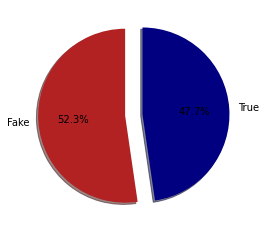

In [10]:
# check if data is well balanced
label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
plt.pie(label_size, explode = [0.1, 0.1], colors=['firebrick', 'navy'], startangle=90, shadow= True, labels= ['Fake', 'True'], autopct='%1.1f%%')

In [11]:
# train-validation-test split 70:15:15 ratio

train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], random_state=2018, test_size = 0.3, stratify=data['Target'])

# validation-test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2018, test_size = 0.5, stratify = temp_labels)

In [12]:
# load bert base model 110M params 
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number of texts')

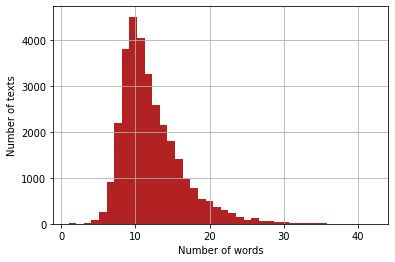

In [13]:
# prepare input data 
# plot histogram of the number of words in train data. 'title' 
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40, color = 'firebrick')
plt.xlabel('Number of words')
plt.ylabel('Number of texts')

In [14]:
# bert tokenizer functionality 
sample_data = ["Build fake news model.", "Using Bert"]

tokenized_sample_data = tokenizer.batch_encode_plus(sample_data, padding = True)

tokenized_sample_data

{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 102, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 0]]}

In [15]:
# majority of titles above have word length under 15. so max title length will be set as 15
MAX_LENGTH = 15

# tokenize and encode sequences in the train set 
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(), 
    max_length = MAX_LENGTH, 
    pad_to_max_length = True, 
    truncation = True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(), 
    max_length = MAX_LENGTH, 
    pad_to_max_length = True, 
    truncation = True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(), 
    max_length = MAX_LENGTH, 
    pad_to_max_length = True, 
    truncation = True
)


In [16]:
# convert lists to tensors 
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_val['input_ids'])
test_mask = torch.tensor(tokens_val['attention_mask'])
test_y = torch.tensor(val_labels.tolist())

In [17]:
# data loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)


In [18]:
# freeze all pretrained model weights
for param in bert.parameters(): 
  param.requires_grad = False 


In [25]:
# define model architecture
class BERT_Arch(nn.Module): 
  def __init__(self, bert): 
    super(BERT_Arch, self).__init__()
    self.bert = bert
    self.dropout = nn.Dropout(0.1) # dropout layer 
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(768, 512)
    self.fc_new_1 = nn.Linear(512, 300)
    self.fc_new_2 = nn.Linear(300, 2)
    self.fc2 = nn.Linear(512, 2) 
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, sent_id, mask): 
    cls_hs = self.bert(sent_id, attention_mask = mask)['pooler_output'] # pass inputs to the model 
    x = self.fc1(cls_hs) 
    x = self.relu(x) 
    x = self.dropout(x) 
    x = self.fc2(x) 
    x = self.softmax(x) 
    return x 

model = BERT_Arch(bert)
model.to(device)

# Define hyperparameters (optimizer, weights of the classes and the epochs) 
# define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(), 
                  lr = 1e-5) # learning rate

# define loss function 
cross_entropy = nn.NLLLoss() 

# number of training epochs 
epochs = 10

In [26]:
# defining training and evaluation function 
def train(): 
  model.train() 
  total_loss, total_accuracy = 0, 0 

  for step, batch in enumerate(train_dataloader): # iterate over batches 

    # progress update every 50 batches
    if step % 50 == 0 and not step == 0: 
      print(' Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
    
    # push batch to the gpu
    batch = [r for r in batch]
    sent_id, mask, labels = batch 
    sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)

    # clear previously calculated gradients 
    model.zero_grad() 

    # get model predictions for current batch 
    preds = model(sent_id, mask) 

    # compute loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients 
    loss.backward() 

    # clip gradients to 1.0 it helps preventing exploding gradients problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters 
    optimizer.step() 

    # model prediction back to cpu 
    preds = preds.detach().cpu().numpy()

  # compute training loss of the epoch 
  # reshape predictions in form of (# samples, # classes)
  avg_loss = total_loss / len(train_dataloader)

  return avg_loss

def evaluate(): 
  print("\n Evaluating....")
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0 

  # iterate over batches 
  for step, batch in enumerate(val_dataloader): 
    # progress update every 50 batches
    if step % 50 == 0 and not step == 0: 

      # calculate elapsed time in minutes 
      print(" Batch {:>5,} of {:>5,}.".format(step, len(val_dataloader)))

    # report progress
    # push the batch to GPU
    batch = [t for t in batch]
    sent_id, mask, labels = batch 
    sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)

    # deactivate autograd
    with torch.no_grad(): 
      # model predictions
      preds = model(sent_id, mask) 

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels) 

      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
    
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss





In [27]:
# Train and predict 
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch 
train_losses = []
valid_losses = []

for epoch in range(epochs): 
  print("\n Epoch {:} / {:}".format(epoch + 1, epochs))

  # train model 
  train_loss = train() 

  # evalueate model 
  valid_loss = evaluate() 

  # save the best model 
  if valid_loss < best_valid_loss: 
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'c2_new_model_weights.pt')

  # append training and validation loss
  train_losses.append(train_loss) 
  valid_losses.append(valid_loss) 

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
 Batch    50 of   983.
 Batch   100 of   983.
 Batch   150 of   983.
 Batch   200 of   983.
 Batch   250 of   983.
 Batch   300 of   983.
 Batch   350 of   983.
 Batch   400 of   983.
 Batch   450 of   983.
 Batch   500 of   983.
 Batch   550 of   983.
 Batch   600 of   983.
 Batch   650 of   983.
 Batch   700 of   983.
 Batch   750 of   983.
 Batch   800 of   983.
 Batch   850 of   983.
 Batch   900 of   983.
 Batch   950 of   983.

 Evaluating....
 Batch    50 of   211.
 Batch   100 of   211.
 Batch   150 of   211.
 Batch   200 of   211.

Training Loss: 0.563
Validation Loss: 0.484

 Epoch 2 / 10
 Batch    50 of   983.
 Batch   100 of   983.
 Batch   150 of   983.
 Batch   200 of   983.
 Batch   250 of   983.
 Batch   300 of   983.
 Batch   350 of   983.
 Batch   400 of   983.
 Batch   450 of   983.
 Batch   500 of   983.
 Batch   550 of   983.
 Batch   600 of   983.
 Batch   650 of   983.
 Batch   700 of   983.
 Batch   750 of   983.
 Batch   800 of   983.
 Batch   85

In [28]:
for epoch in range(epochs): 
  print("\n Epoch {:} / {:}".format(epoch + 1, epochs))

  # train model 
  train_loss = train() 

  # evalueate model 
  valid_loss = evaluate() 

  # save the best model 
  if valid_loss < best_valid_loss: 
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'c2_new_model_weights.pt')

  # append training and validation loss
  train_losses.append(train_loss) 
  valid_losses.append(valid_loss) 

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
 Batch    50 of   983.
 Batch   100 of   983.
 Batch   150 of   983.
 Batch   200 of   983.
 Batch   250 of   983.
 Batch   300 of   983.
 Batch   350 of   983.
 Batch   400 of   983.
 Batch   450 of   983.
 Batch   500 of   983.
 Batch   550 of   983.
 Batch   600 of   983.
 Batch   650 of   983.
 Batch   700 of   983.
 Batch   750 of   983.
 Batch   800 of   983.
 Batch   850 of   983.
 Batch   900 of   983.
 Batch   950 of   983.

 Evaluating....
 Batch    50 of   211.
 Batch   100 of   211.
 Batch   150 of   211.
 Batch   200 of   211.

Training Loss: 0.310
Validation Loss: 0.268

 Epoch 2 / 10
 Batch    50 of   983.
 Batch   100 of   983.
 Batch   150 of   983.
 Batch   200 of   983.
 Batch   250 of   983.
 Batch   300 of   983.
 Batch   350 of   983.
 Batch   400 of   983.
 Batch   450 of   983.
 Batch   500 of   983.
 Batch   550 of   983.
 Batch   600 of   983.
 Batch   650 of   983.
 Batch   700 of   983.
 Batch   750 of   983.
 Batch   800 of   983.
 Batch   85

In [30]:
# Move the input tensors to the same device as the model 
test_seq = test_seq.to(device) 
test_mask = test_mask.to(device) 

with torch.no_grad(): 
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy() 

preds = np.argmax(preds, axis = 1) 
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3213
           1       0.92      0.87      0.89      3522

    accuracy                           0.89      6735
   macro avg       0.89      0.89      0.89      6735
weighted avg       0.89      0.89      0.89      6735



In [31]:
# testing on unseen data
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",     # Fake
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",               # Fake
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",           # True
                    "Trump administration issues new rules on U.S. visa waivers"                          # True
                    ]

# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

unseen_seq = unseen_seq.to(device) 
unseen_mask = unseen_mask.to(device) 

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 0, 0])